# 5- From local to global explanations with SDP
### (Reproduction of figures 9 , 10 and 11)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import shap
from acv_explainers import ACVTree
from acv_explainers.utils import *
from experiments.exp_linear_gmm import *

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns

import random 
import numpy as np
import pandas as pd

random.seed(212)
np.random.seed(212)

### Load data

In [2]:
X = pd.read_csv('/home/samoukou/Documents/ACV/data/lucas0_train.csv')
X.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


In [3]:
y = X.Lung_cancer.values
X.drop(['Lung_cancer'], axis=1, inplace=True)

In [4]:
num_features = X.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [5]:
# Model 

tree = DecisionTreeClassifier(min_samples_leaf=20, random_state=212)
tree.fit(X_train, y_train)

accuracy_train = roc_auc_score(y_train, tree.predict_proba(X_train)[:, 1])
accuracy_test = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
print('[* TREE *]')
print('train acc = {} --- test acc = {}'.format(accuracy_train, accuracy_test))

forest = RandomForestClassifier(n_estimators=10, min_samples_leaf=2, random_state=212)
forest.fit(X_train, y_train)

accuracy_train = roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])
accuracy_test = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
print('[* FOREST *]')
print('train acc = {} --- test acc = {}'.format(accuracy_train, accuracy_test))

[* TREE *]
train acc = 0.9230919439227646 --- test acc = 0.9127666666666667
[* FOREST *]
train acc = 0.9416321592186097 --- test acc = 0.90515


In [6]:
idx = 267
ind = X_train.values[idx]
y_ind = y_train[idx]
fx = forest.predict(np.expand_dims(ind, 0))[0]

In [7]:
X_train[idx:idx+1]

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing
1690,0,0,0,0,0,0,1,1,0,0,0


In [8]:
print('f(x) = {}, y_ind = {}'.format(fx, y_ind))

f(x) = 0, y_ind = 0


### Build ACVTree for explanations

In [10]:
acvtree = ACVTree(forest, X_train.values)

### Compute $S^\star$ for an example

In [11]:
# params init 
sdp_cluster = []
threshold = 0.5
proba = 0.95
decay = 0.77
index = list(range(X.shape[1]))
algo = 'plugin'
data = X_train.values

acvtree.compute_local_sdp_clf(ind, fx, threshold, proba, index, data, sdp_cluster, decay, verbose=0, C=[[5, 6]])

print('Cluster find by SDP = {}'.format(sdp_cluster))

sdp_importance = []
for c in sdp_cluster:
    value = [acvtree.compute_sdp_clf(ind, fx, threshold, S=chain_l(c), 
             data=data) for i in range(len(forest.estimators_))]

    sdp_importance.append(np.mean(value))

sdp_importance

sdp_importance_name = []
for c in sdp_cluster:
    sdp_importance_name.append(str([X.columns[i] for i in c]))

Cluster find by SDP = [[0, 4, 10], [1, 2, 3, 7, 8, 9, 5, 6]]


<Figure size 1800x1200 with 0 Axes>

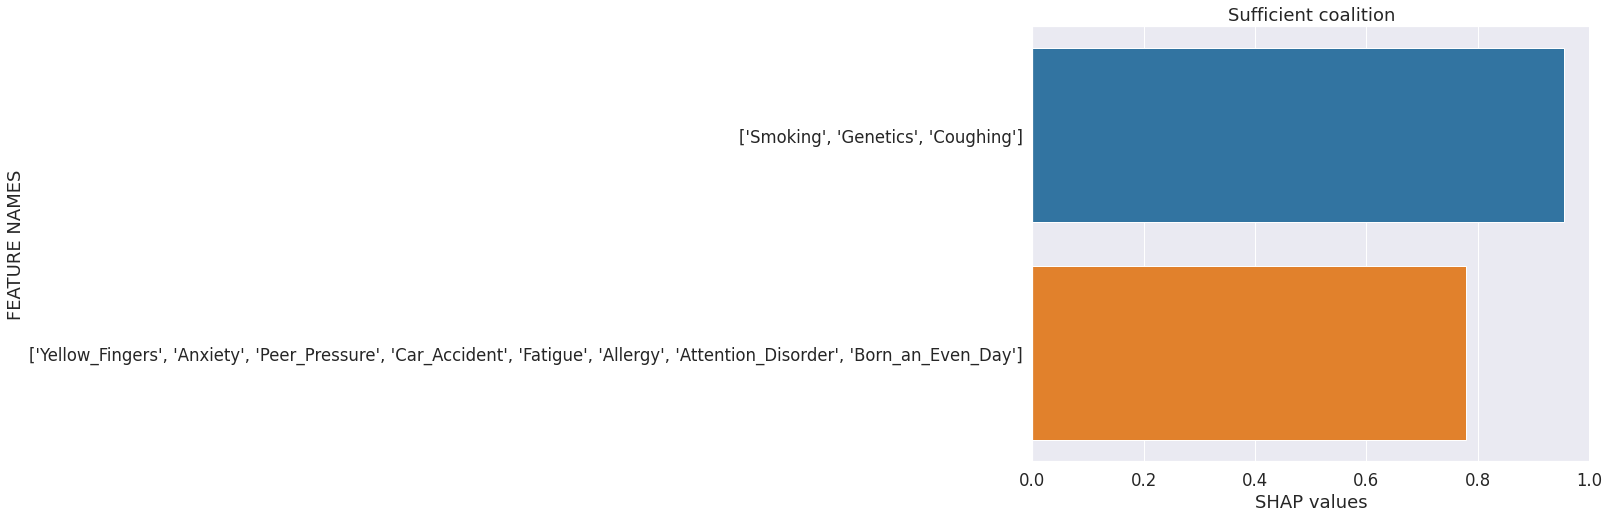

In [12]:
plt.figure(dpi=300)
plot_feature_importance_10(sdp_importance, sdp_importance_name, 'forest_SDP  ', title='Sufficient coalition')

### Figure 9: Sufficient coalition of an observation that has Smoking, Genetic, Coughing at False

### Global SDP on all population (LONG RUNNING TIME $\approx$ 6 hours)

In [14]:
columns_names = [X.columns[i] for i in range(X.shape[1]) ]

In [15]:
sdp_importance_m, sdp_importance, sdp_importance_proba, sdp_importance_coal_count, sdp_importance_variable_count\
= acvtree.global_sdp_importance_clf(data=X_test.values, data_bground=X_train.values, columns_names=columns_names, 
                            global_proba=0.9, decay=0.7, threshold=0.6, proba=0.9, C=C, verbose=0)

100%|██████████| 400/400 [6:09:31<00:00, 55.43s/it]   


<Figure size 1800x1200 with 0 Axes>

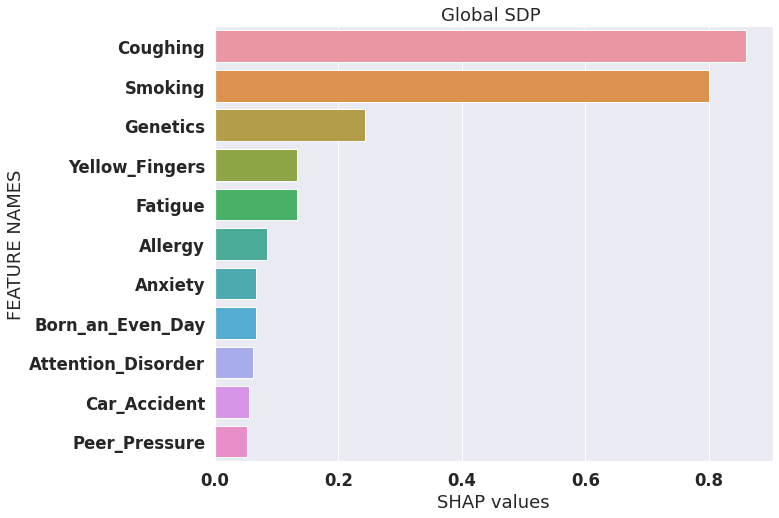

In [16]:
plt.figure(dpi=300)
plot_feature_importance(list(sdp_importance_variable_count.values()), columns_names, 'global sdp  ', title='Global SDP ')

<Figure size 1800x1200 with 0 Axes>

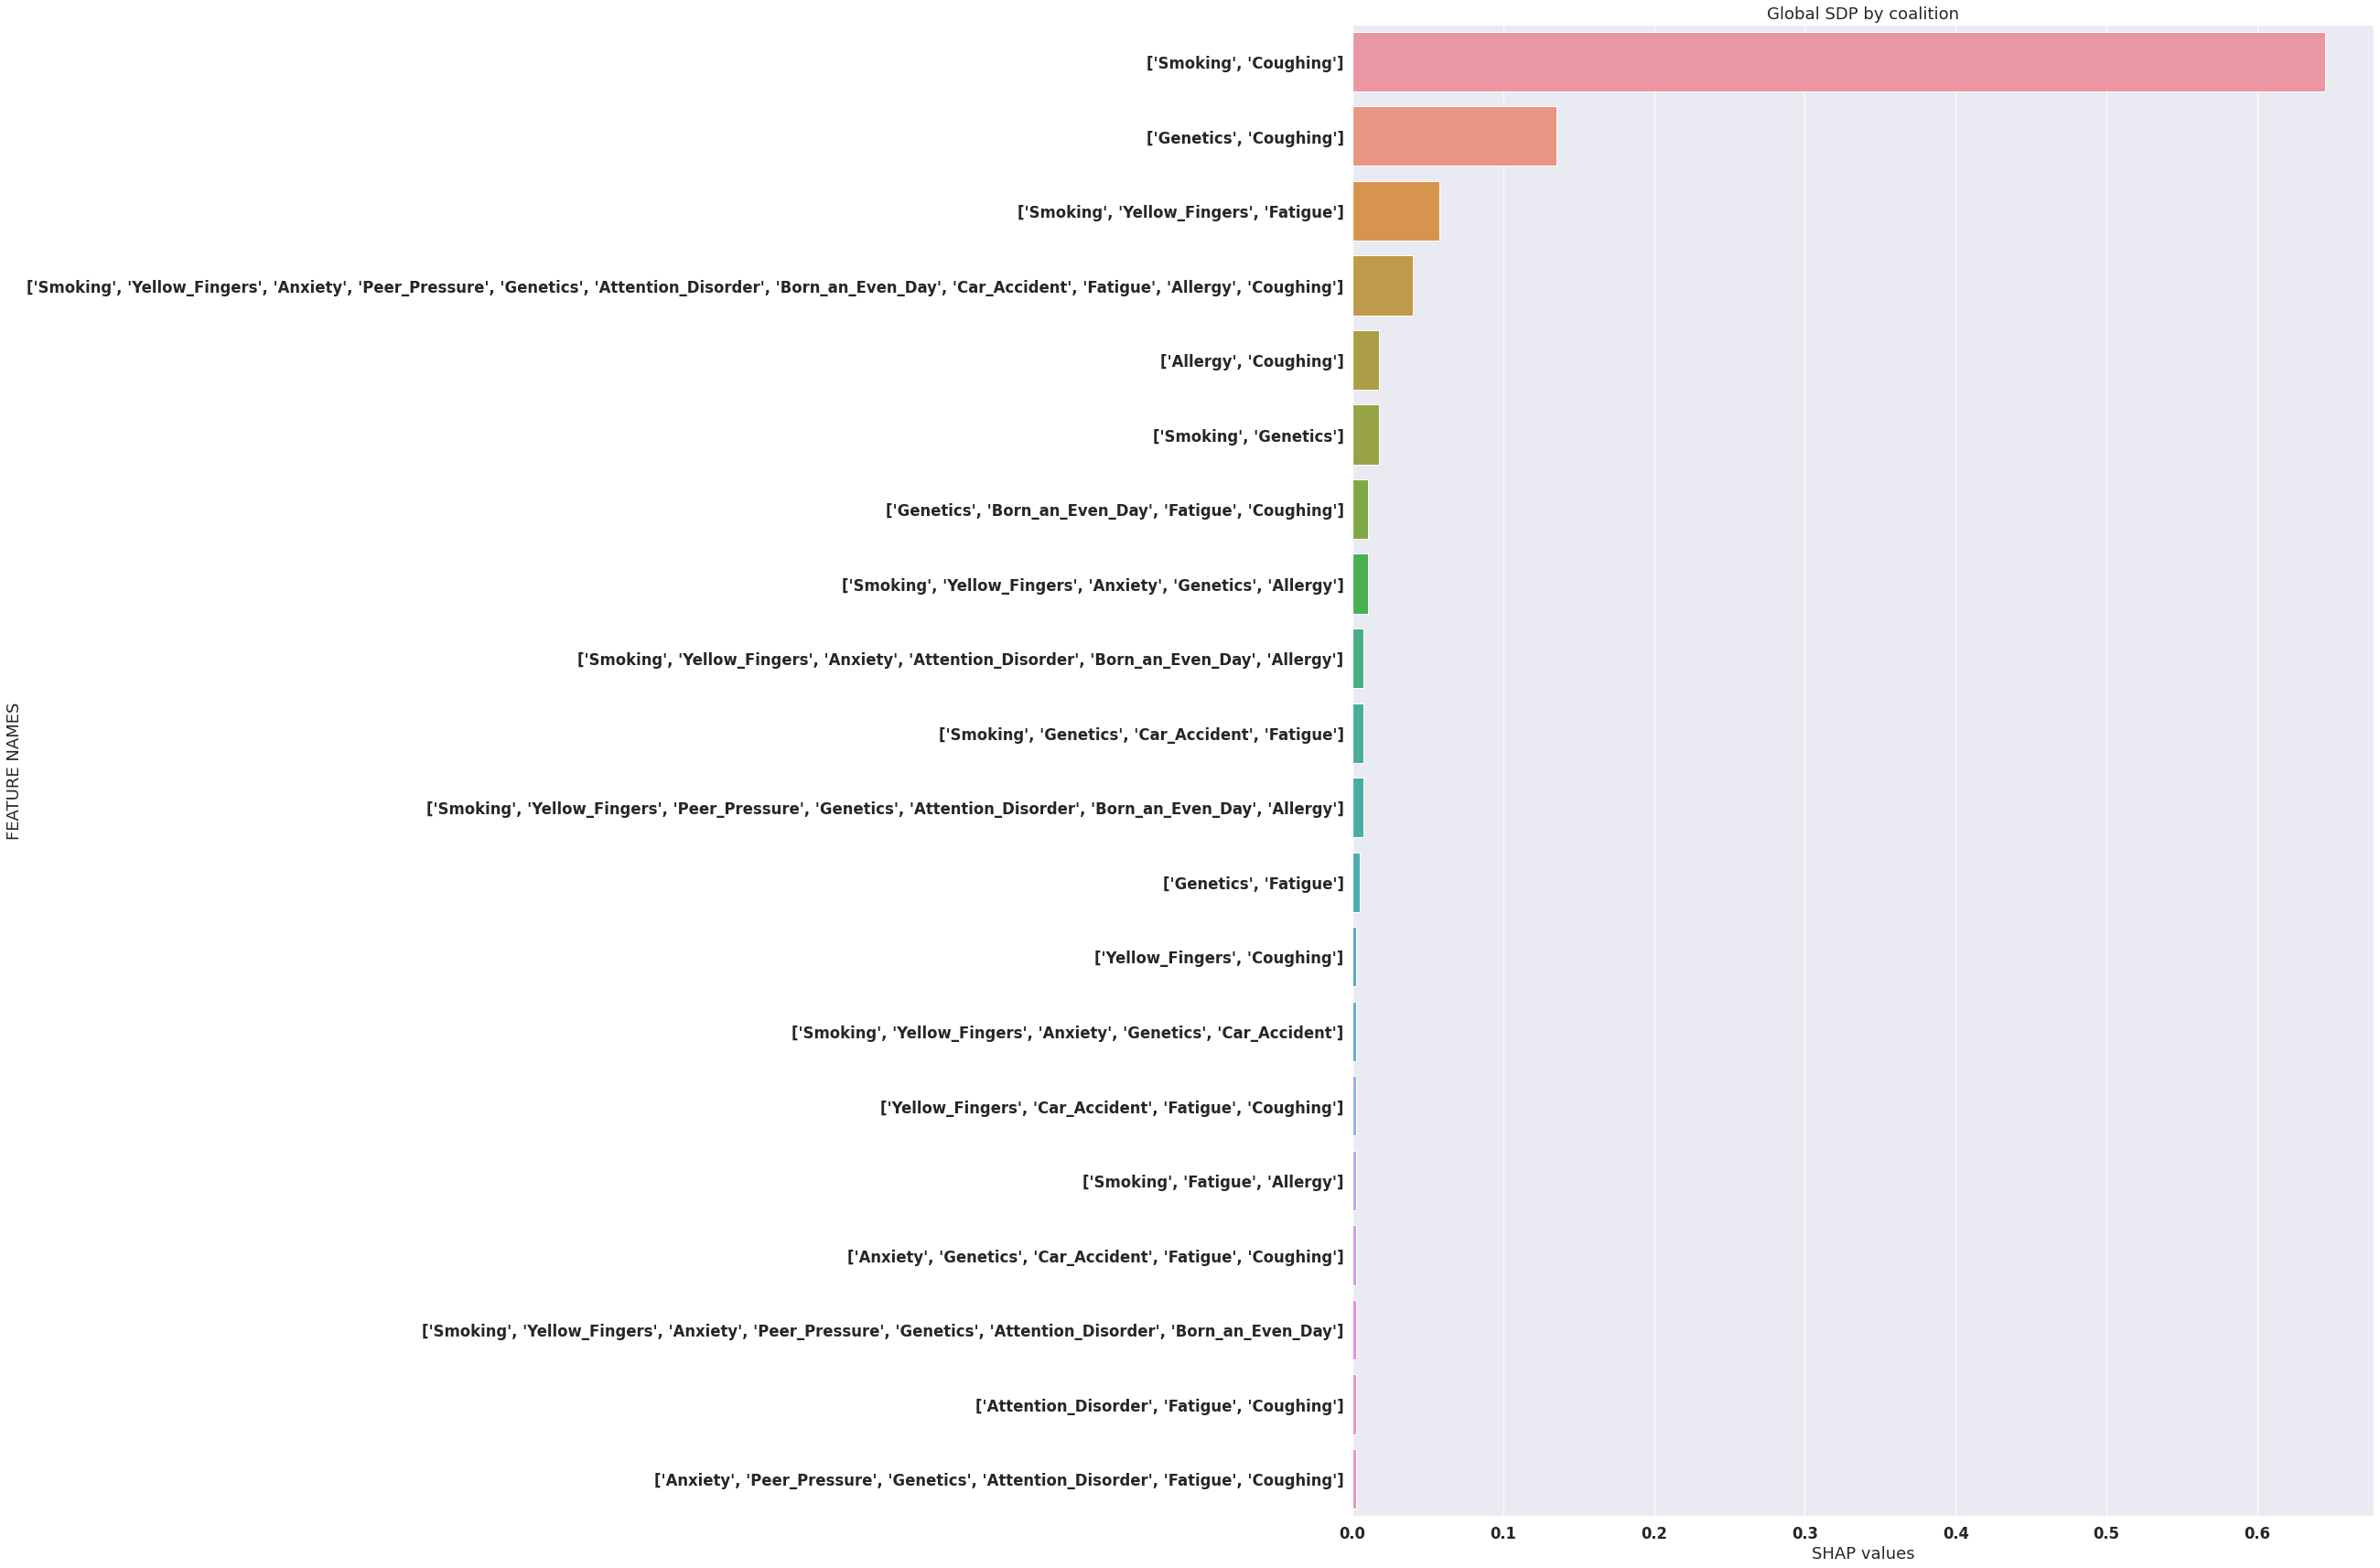

In [17]:
plt.figure(dpi=300)

def plot_feature_importance_coal(importance, names, model_type, xlabel='SHAP values', title=' '):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(20, 30))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('FEATURE NAMES')

plot_feature_importance_coal(list(sdp_importance_coal_count.values()), list(sdp_importance_coal_count.keys()), 'global sdp  ',
                       title='Global SDP by coalition')

### Global SDP when Y=1 (LONG RUNNING TIME $\approx$ 2 hours)

In [18]:
sdp_importance_m, sdp_importance, sdp_importance_proba, sdp_importance_coal_count, sdp_importance_variable_count\
= acvtree.global_sdp_importance_clf(data=X_test.values[y_test>=1], data_bground=X_train.values, columns_names=columns_names, 
                            global_proba=0.9, decay=0.7, threshold=0.6, proba=0.9, C=C, verbose=0)

100%|██████████| 300/300 [3:25:37<00:00, 41.13s/it]  


<Figure size 1800x1200 with 0 Axes>

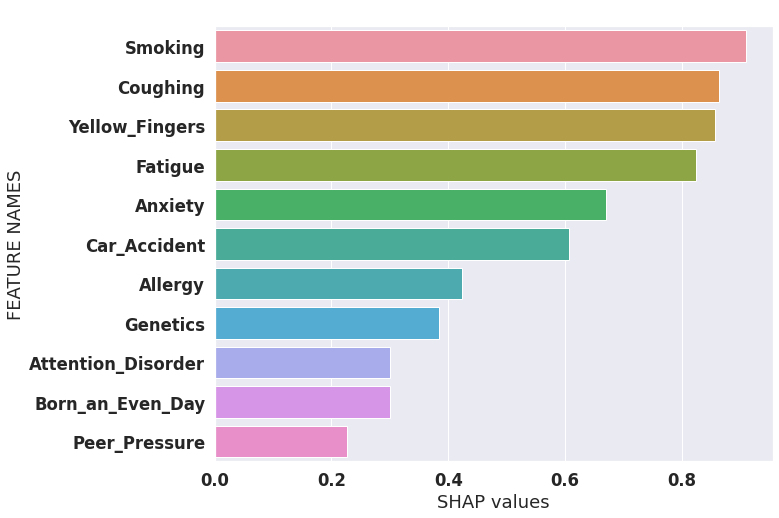

In [19]:
plt.figure(dpi=300)
plot_feature_importance(list(sdp_importance_variable_count.values()), columns_names, 'global sdp  ')

### Figure 11: Global SDP given $Y=1$

<Figure size 1800x1200 with 0 Axes>

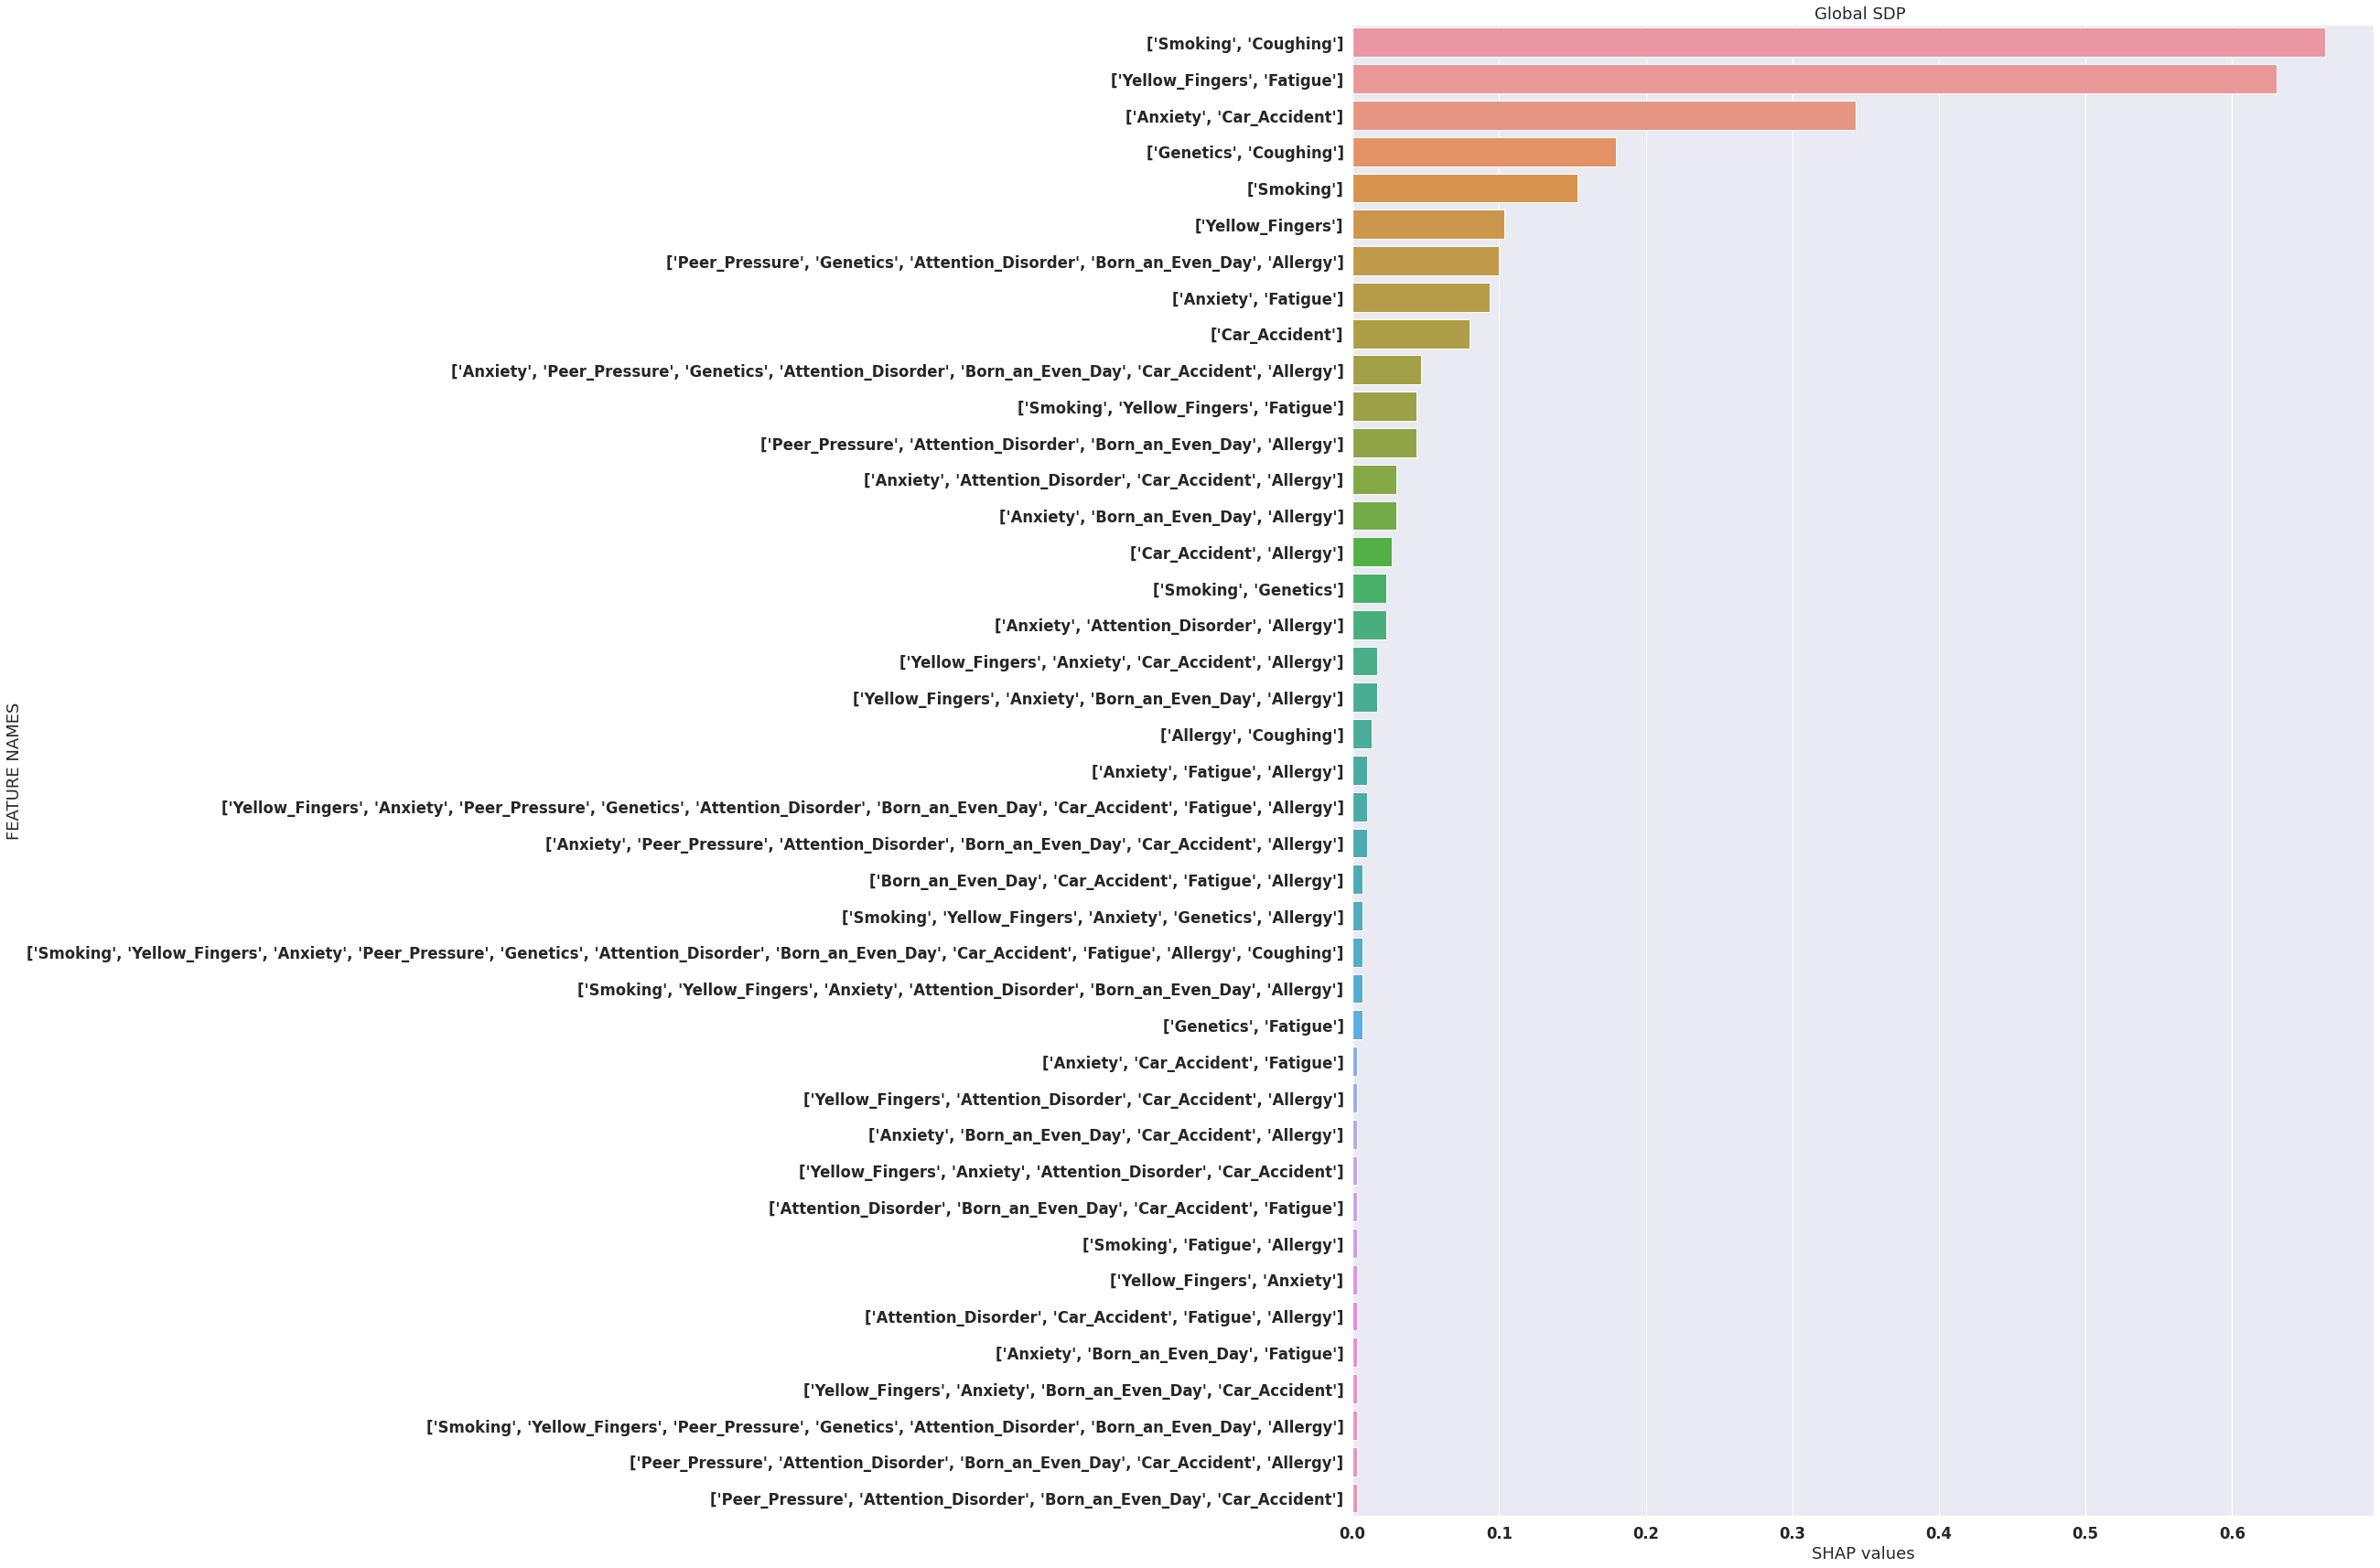

In [20]:
plt.figure(dpi=300)
plot_feature_importance_coal(list(sdp_importance_coal_count.values()), list(sdp_importance_coal_count.keys()), 'global sdp  ', title='Global SDP ')

### Global SDP when Y=0

In [21]:
sdp_importance_m, sdp_importance, sdp_importance_proba, sdp_importance_coal_count, sdp_importance_variable_count\
= acvtree.global_sdp_importance_clf(data=X_test.values[y_test<1], data_bground=X_train.values, columns_names=columns_names, 
                            global_proba=0.9, decay=0.7, threshold=0.6, proba=0.9, C=C, verbose=0)

100%|██████████| 100/100 [2:23:30<00:00, 86.11s/it]  


<Figure size 1800x1200 with 0 Axes>

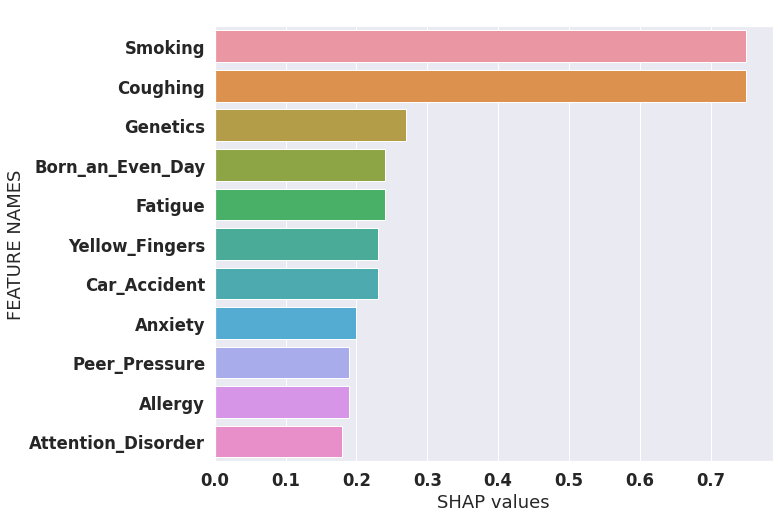

In [22]:
plt.figure(dpi=300)
plot_feature_importance(list(sdp_importance_variable_count.values()), columns_names, 'global sdp  ')

### Figure 10: Global SDP given $Y=0$

<Figure size 1800x1200 with 0 Axes>

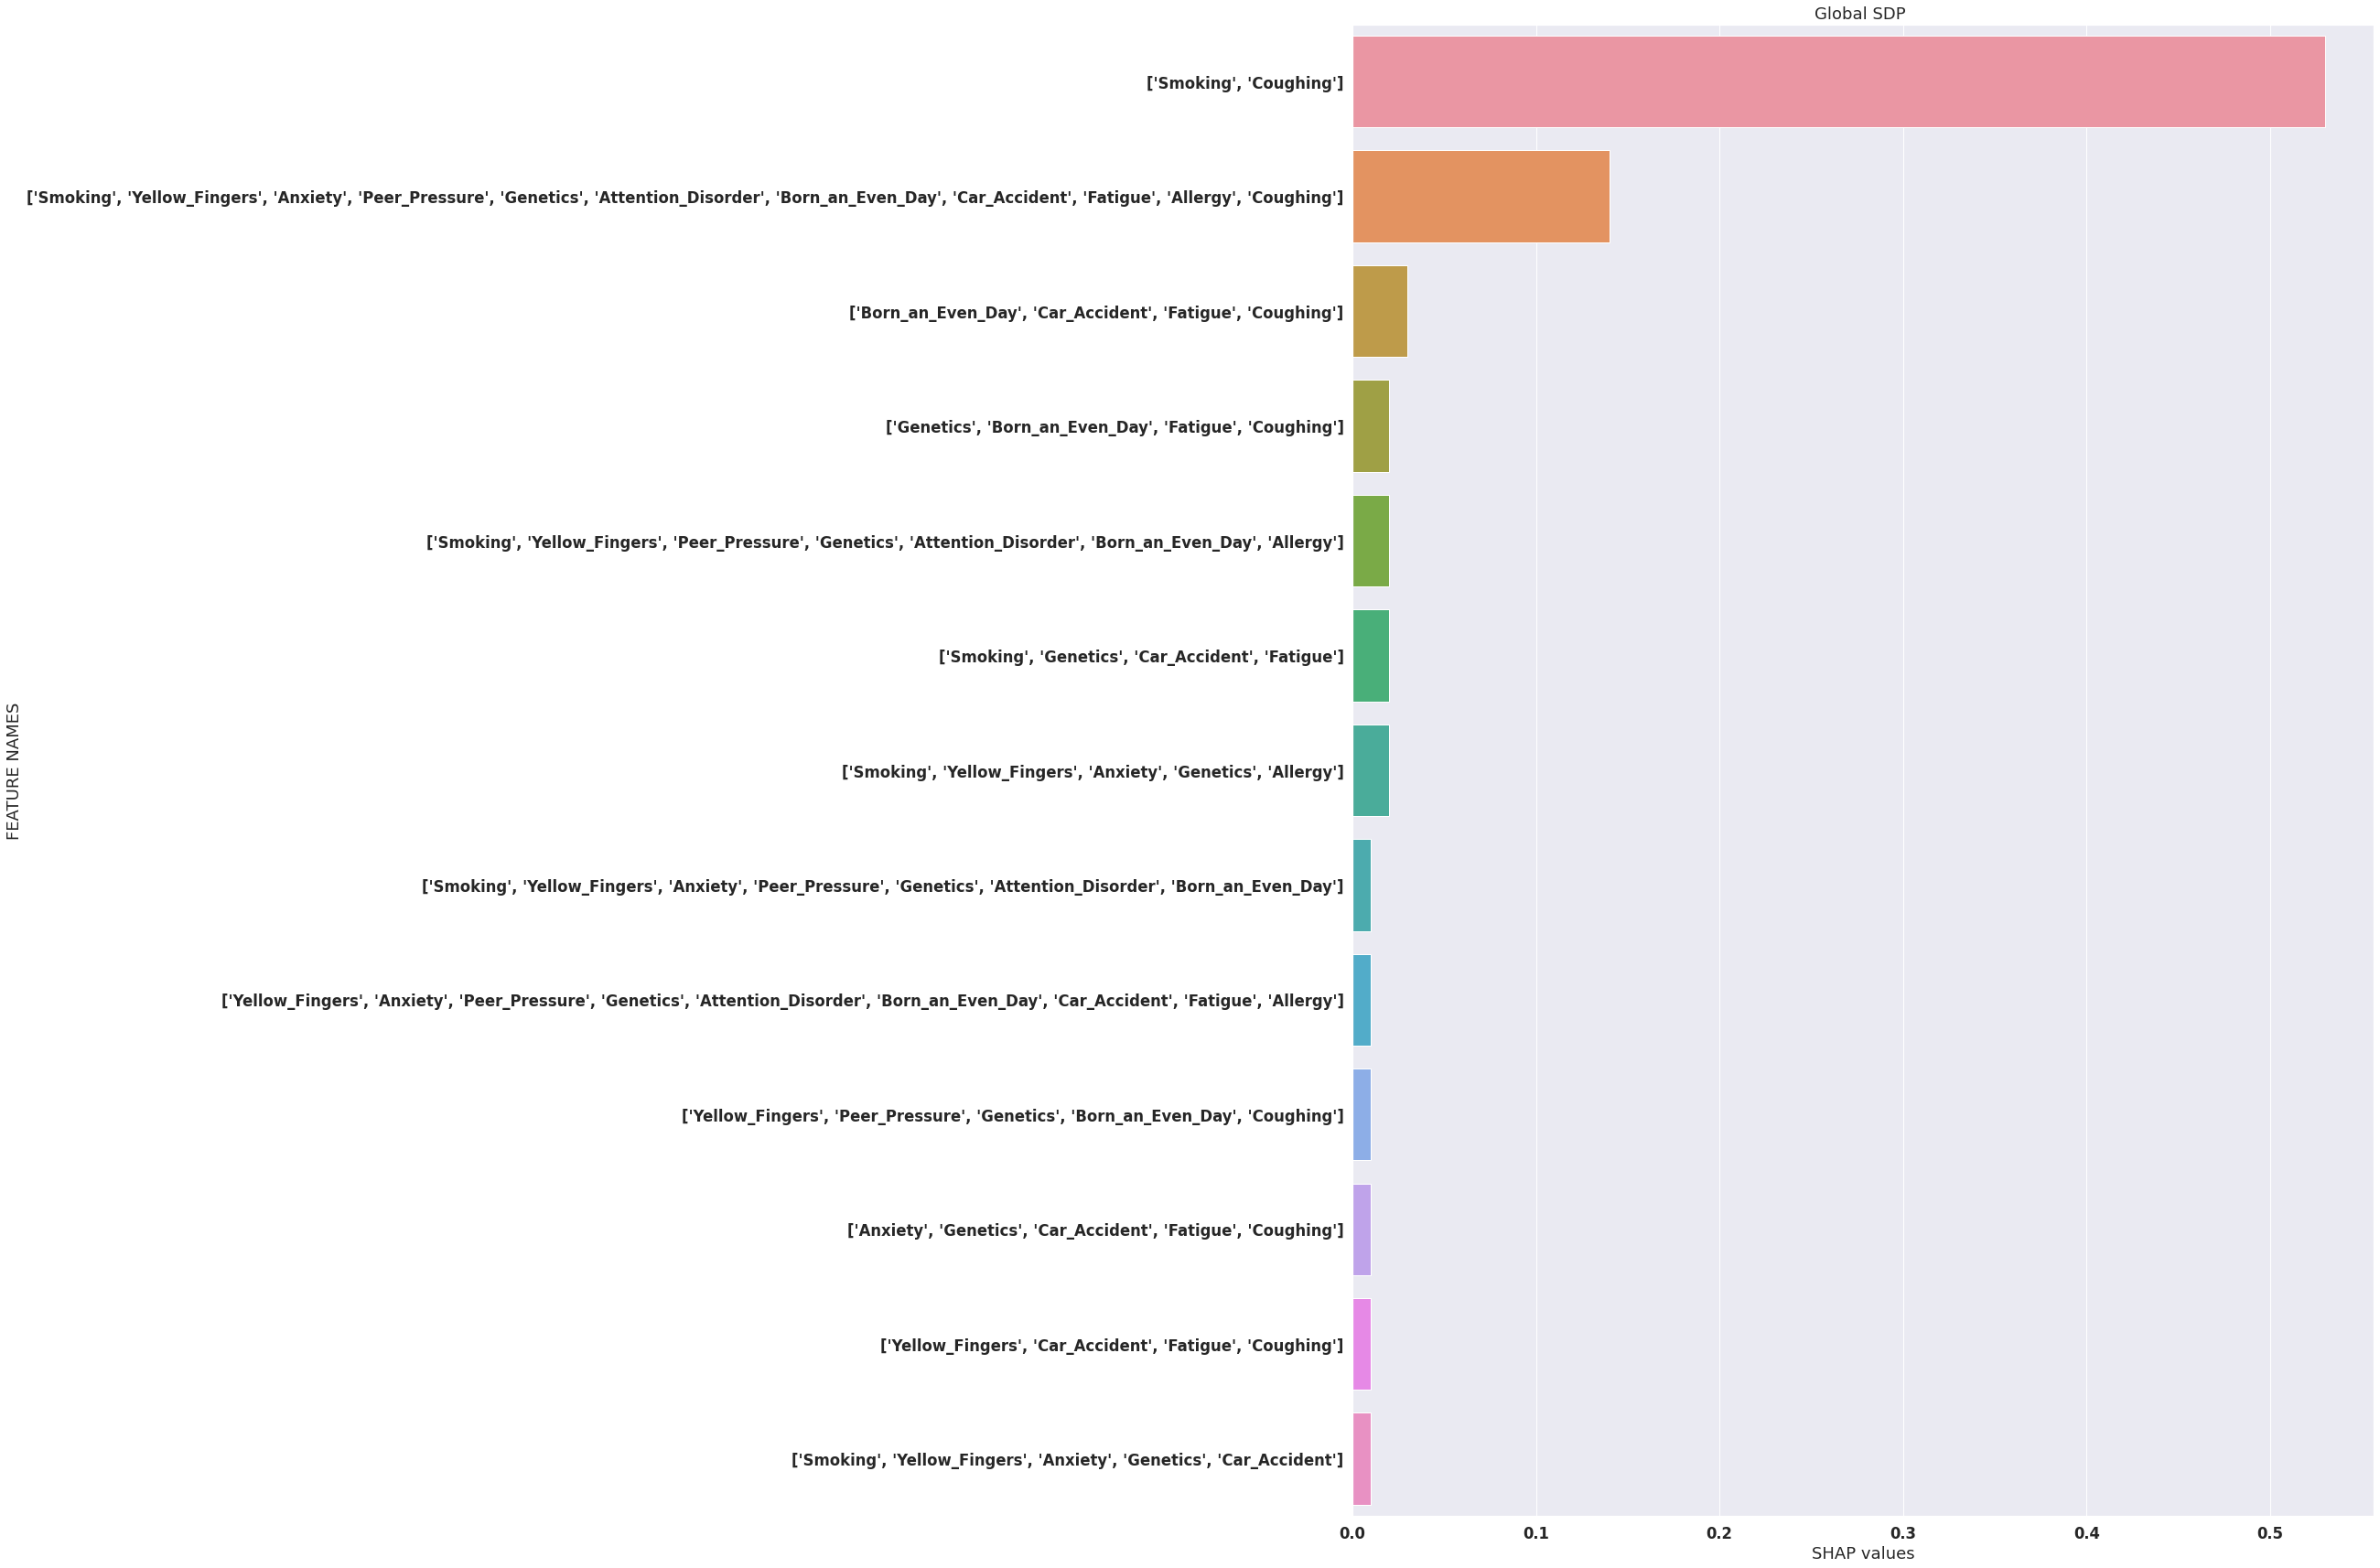

In [24]:
plt.figure(dpi=300)
plot_feature_importance_coal(list(sdp_importance_coal_count.values()), list(sdp_importance_coal_count.keys()), 'global sdp  ', title='Global SDP ')